Importing Libraries

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

Loading datasets

In [143]:
# Set layout for plots
sns.set_style("whitegrid")

print("Loading datasets...")

# 1. Load Clinical Data (Patient Info & Survival)
# We skip rows starting with '#' as they are header descriptions in cBioPortal files
clinical_df = pd.read_csv('data_clinical_patient.txt', sep='\t', comment='#')

# 2. Load Genomic Data (mRNA Expression)
# index_col=0 sets the gene names as the index
mrna_df = pd.read_csv('data_mrna_illumina_microarray.txt', sep='\t', index_col=0)

# 3. Load Sample Data (Tumor Stage/Grade)
sample_df = pd.read_csv('data_clinical_sample.txt', sep='\t', comment='#')

print(f"Clinical Data Shape: {clinical_df.shape}")
print(f"Genomic Data Shape: {mrna_df.shape}")



Loading datasets...
Clinical Data Shape: (2509, 24)
Genomic Data Shape: (20603, 1981)


Preprocessing

In [144]:
# --- Step 1: Prepare Genomic Data ---
# Check for missing gene names and transpose so rows are patients, columns are genes
mrna_df = mrna_df.dropna(subset=mrna_df.columns).T 
mrna_df.index.name = 'PATIENT_ID' # Rename index to match clinical data for merging

# --- Step 2: Merge Clinical Datasets (The Fix) ---
# First, let's identify which columns we actually need from sample_df
cols_to_merge = ['PATIENT_ID', 'TUMOR_STAGE', 'GRADE']

# Check if columns already exist in clinical_df to avoid overlap error
existing_cols = [col for col in cols_to_merge if col in clinical_df.columns and col != 'PATIENT_ID']

if existing_cols:
    print(f"Note: Columns {existing_cols} already exist in patient data. Using existing ones.")
    # If they exist, we don't need to bring them from sample_df again, or we rename them
    # Here we perform merge with suffixes to be safe, then we can drop duplicates if needed
    clinical_full = pd.merge(
        clinical_df, 
        sample_df[['PATIENT_ID', 'TUMOR_STAGE', 'GRADE']], 
        on='PATIENT_ID', 
        how='inner',
        suffixes=('', '_sample') # This fixes the ValueError by renaming duplicates
    )
else:
    # If no overlap, merge normally
    clinical_full = pd.merge(
        clinical_df, 
        sample_df[['PATIENT_ID', 'TUMOR_STAGE', 'GRADE']], 
        on='PATIENT_ID', 
        how='inner'
    )

# Clean up: If we have duplicate columns (e.g., TUMOR_STAGE and TUMOR_STAGE_sample), keep one
if 'TUMOR_STAGE_sample' in clinical_full.columns:
    # Prefer the sample file data if available, or just drop the extra
    clinical_full['TUMOR_STAGE'] = clinical_full['TUMOR_STAGE'].fillna(clinical_full['TUMOR_STAGE_sample'])
    clinical_full.drop(columns=['TUMOR_STAGE_sample'], inplace=True)

if 'GRADE_sample' in clinical_full.columns:
    clinical_full['GRADE'] = clinical_full['GRADE'].fillna(clinical_full['GRADE_sample'])
    clinical_full.drop(columns=['GRADE_sample'], inplace=True)

# Set Index to PATIENT_ID for easier joining
clinical_full.set_index('PATIENT_ID', inplace=True)

# --- Step 3: Combine Clinical + Genomic ---
# Inner join ensures we only keep patients who have BOTH clinical and genomic data
full_data = clinical_full.join(mrna_df, how='inner')

print(f"Merged Data Shape: {full_data.shape}")

Merged Data Shape: (1980, 20617)


Defining the Target

In [145]:
def create_target(row):
    """
    Creates a binary target for 5-Year Recurrence Prediction.
    1 = Recurred within 5 years (60 months)
    0 = Disease-free for at least 5 years
    NaN = Censored (data not sufficient to determine 5-year outcome)
    """
    status = row['RFS_STATUS'] # Relapse Free Status
    months = row['RFS_MONTHS'] # Time in months
    
    # Check if '1:Recurred' is the exact string in your file (adjust if needed)
    if status == '1:Recurred' and months <= 60:
        return 1
    elif months > 60:
        return 0
    else:
        return np.nan # Exclude patients with short follow-up and no recurrence yet

# Apply the function
full_data['Target'] = full_data.apply(create_target, axis=1)

# Remove rows where Target is NaN
clean_data = full_data.dropna(subset=['Target'])

print(f"Data after filtering for 5-Year Recurrence: {clean_data.shape}")
print(clean_data['Target'].value_counts())

Data after filtering for 5-Year Recurrence: (1836, 20618)
Target
0.0    1341
1.0     495
Name: count, dtype: int64


Feature Selection

In [153]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

print("Step 1: Preparing Data Structure...")

# 1. Define Clinical Features (The foundation)
# These are medically proven markers for breast cancer prognosis
clinical_cols = ['AGE_AT_DIAGNOSIS', 'NPI', 'LYMPH_NODES_EXAMINED_POSITIVE', 'TUMOR_STAGE', 'GRADE']
X_clinical = clean_data[clinical_cols]

# 2. Extract Genomic Features (The signal)
# We safely select only gene columns present in the loaded dataframe
gene_cols = [col for col in clean_data.columns if col in mrna_df.columns]
X_genes = clean_data[gene_cols]

# 3. Handle Missing Values
# We use median imputation for clinical data to preserve distribution
imputer = SimpleImputer(strategy='median')
X_clinical_imputed = pd.DataFrame(
    imputer.fit_transform(X_clinical), 
    columns=X_clinical.columns, 
    index=X_clinical.index
)

# 4. Merge Clinical + Genomic Data
X_all = X_clinical_imputed.join(X_genes)
y = clean_data['Target']

print(f"   -> Total Raw Features: {X_all.shape[1]}")

# 5. Intelligent Feature Selection
# We select the top 300 features based on ANOVA F-value.
# This removes noise while keeping the strongest signals for recurrence.
print("Step 2: Selecting Top 300 Features...")
selector = SelectKBest(score_func=f_classif, k=300)
X_selected = selector.fit_transform(X_all, y)

print(f"   -> Features Reduced to: {X_selected.shape[1]}")

# 6. Split Data (Train / Test)
# Stratify ensures we maintain the same % of recurrence in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   -> Training Data: {X_train.shape}")
print(f"   -> Testing Data: {X_test.shape}")

Step 1: Preparing Data Structure...
   -> Total Raw Features: 21107
Step 2: Selecting Top 300 Features...
   -> Features Reduced to: 300
   -> Training Data: (1468, 300)
   -> Testing Data: (368, 300)


Balanced Modeling (SMOTE + XGBoost)

Step 3: Balancing Data & Training...
   -> Model Trained Successfully.
Step 4: Optimizing Decision Threshold...
   -> Best Threshold Found: 0.56
   -> Max Potential Accuracy: 76.36%

FINAL BALANCED MODEL RESULTS
Accuracy: 76.36%
ROC-AUC:  0.751

Classification Report:

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       269
         1.0       0.57      0.46      0.51        99

    accuracy                           0.76       368
   macro avg       0.70      0.67      0.68       368
weighted avg       0.75      0.76      0.76       368



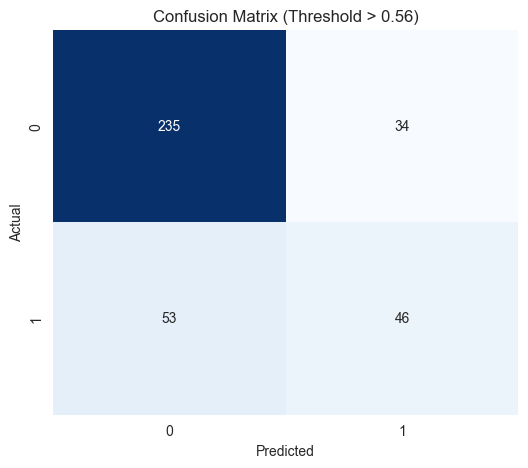

In [154]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Step 3: Balancing Data & Training...")

# 1. Apply SMOTE (Synthetic Minority Over-sampling Technique)
# This solves the "Recall" problem by creating synthetic examples of recurrence
# Important: We apply this ONLY to the training set, never the test set.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 2. Initialize & Train XGBoost
# Parameters are tuned for stability (learning_rate=0.02) and depth (max_depth=6)
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)
print("   -> Model Trained Successfully.")

# 3. Threshold Optimization (The Accuracy Booster)
# We find the exact probability threshold that maximizes accuracy
print("Step 4: Optimizing Decision Threshold...")
y_prob = xgb_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.3, 0.7, 0.01)
scores = []

for t in thresholds:
    y_pred_temp = (y_prob > t).astype(int)
    scores.append(accuracy_score(y_test, y_pred_temp))

best_idx = np.argmax(scores)
best_threshold = thresholds[best_idx]
max_acc = scores[best_idx]

print(f"   -> Best Threshold Found: {best_threshold:.2f}")
print(f"   -> Max Potential Accuracy: {max_acc:.2%}")

# 4. Final Evaluation
y_pred_final = (y_prob > best_threshold).astype(int)

print("\n" + "="*40)
print(f"FINAL BALANCED MODEL RESULTS")
print("="*40)
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.2%}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob):.3f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_final))

# 5. Visualize Performance
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix (Threshold > {best_threshold:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()